In [1]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for analysis
from seizure_detection_pipeline import prepare_segment, TRAIN_WIN, PRED_WIN

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

2024-07-09 16:21:10.815668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 16:21:12.009138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-09 16:21:13.849704: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 16:21:13.867726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

## Config

In [3]:
usr,passpath,datapath,prodatapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [4]:
patient_table

,ptID,ieeg_ids,lf_stim,hf_stim,typical,mtle,interictal_training
13,HUP224,"[HUP224_phaseII, HUP224_CCEP]",1,0,0.0,1.0,"[HUP224_phaseII, 5915]"
14,HUP225,"[HUP225_phaseII, HUP225_CCEP]",1,0,1.0,0.0,"[HUP225_phaseII, 71207]"
15,HUP229,"[HUP229_phaseII, HUP229_CCEP]",1,0,1.0,1.0,"[HUP229_phaseII, 149146]"
16,HUP230,"[HUP230_phaseII, HUP230_CCEP]",1,0,1.0,1.0,"[HUP230_phaseII, 25350]"
17,HUP235,"[HUP235_phaseII, HUP235_CCEP]",1,1,1.0,1.0,"[HUP235_phaseII, 307651]"
18,HUP238,"[HUP238_phaseII, HUP238_CCEP]",1,0,1.0,1.0,"[HUP238_phaseII, 100011]"
19,HUP246,"[HUP246_phaseII, HUP246_CCEP]",1,0,1.0,1.0,"[HUP246_phaseII, 100000]"
20,HUP247,"[HUP247_phaseII, HUP247_CCEP]",1,0,1.0,0.0,"[HUP247_phaseII, 17590]"
21,HUP249,"[HUP249_phaseII, HUP249_CCEP]",1,0,0.0,0.0,"[HUP249_phaseII, 24112]"
22,HUP250,"[HUP250_phaseII, HUP250_CCEP]",1,0,1.0,0.0,"[HUP250_phaseII, 24841]"


## Formatting Model Predictions

### Channel agreement functions

In [5]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

### Channel level

In [6]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"predicted_channels.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)



In [7]:
pred_channels_wdice.to_pickle(ospj(prodatapath,f"predicted_channels_wdice.pkl"))
pred_channels_wkappa.to_pickle(ospj(prodatapath,f"predicted_channels_wkappa.pkl"))

### Region level

Unnecessary replication here. I should just use pred_channels_wannots and then apply the region function to create pred_regions_wannots and then drop all the channel ones.

In [8]:
# TODO Unnecessary Cell?
# I should just go through eac
# Tranforming human annotations to regions
pt_groups = annotations_df.groupby('Patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            annotations_df.at[idx,col+'_rs'] = electrode_locals
        annotations_df.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique()

In [9]:
# Transforming model predictions to regions
pt_groups = predicted_channels.groupby('Patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    for idx,row in group.iterrows():
        for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(row[col])]['label'].unique() if l != 'EmptyLabel'])
            predicted_channels.at[idx,col.split('_')[0]+'_rs_'+col.split('_')[2]] = electrode_locals.astype(object)

In [10]:
predicted_channels.Patient.unique()

array(['HUP229', 'CHOP035', 'HUP230', 'CHOP026', 'CHOP041', 'CHOP028',
       'HUP257', 'HUP238', 'HUP266', 'CHOP037', 'HUP246', 'HUP247',
       'HUP253', 'HUP261', 'HUP249', 'HUP250', 'HUP235', 'CHOP045',
       'CHOP005', 'HUP224', 'CHOP024', 'HUP263', 'HUP225'], dtype=object)

In [11]:
predicted_channels[['Patient','iEEG_ID','model','threshold','ueo_rs_strict']].head(12)
# predicted_channels.loc[predicted_channels.Patient == 'CHOP005',['Patient','iEEG_ID','model','threshold','ueo_rs_strict']].head()

,Patient,iEEG_ID,model,threshold,ueo_rs_strict
9659,HUP229,HUP229_phaseII,WVNT,1.00,[]
9635,HUP229,HUP229_phaseII,NRG,0.85,"[ left amygdala , left superior temporal , l..."
9634,HUP229,HUP229_phaseII,NRG,0.80,"[ left amygdala , left superior temporal , l..."
9633,HUP229,HUP229_phaseII,NRG,0.75,"[ left amygdala , left superior temporal , l..."
9632,HUP229,HUP229_phaseII,NRG,0.70,"[ left amygdala , left superior temporal , l..."
9631,HUP229,HUP229_phaseII,NRG,0.65,"[ left amygdala , left superior temporal , l..."
9630,HUP229,HUP229_phaseII,NRG,0.60,"[ left amygdala , left superior temporal , l..."
9629,HUP229,HUP229_phaseII,NRG,0.55,"[ left amygdala , left superior temporal , l..."
9628,HUP229,HUP229_phaseII,NRG,0.50,"[ left amygdala , left superior temporal , l..."
9627,HUP229,HUP229_phaseII,NRG,0.45,"[ left amygdala , left superior temporal , l..."


In [12]:
pred_regions_wannots = pd.merge_asof(predicted_channels,
                                        annotations_df[['approximate_onset','Patient','all_rs','ueo_consensus_rs','ueo_any_rs','sec_consensus_rs','sec_any_rs']],
                                        on='approximate_onset',by='Patient',
                                        tolerance = 240,
                                        direction='nearest',
                                        allow_exact_matches=True)
pred_regions_wannots.dropna(axis=0,subset='stim',inplace=True)
pred_regions_wannots.sort_values(['Patient','iEEG_ID','approximate_onset','threshold','model'],inplace=True)

In [13]:
annotations_df

,Seizure_ID,clinician,Patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,...,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any,ueo_consensus_rs,ueo_any_rs,sec_consensus_rs,sec_any_rs,all_rs
27,HUP229_1,"[CK, DZ, EC]",HUP229,"[[False, False, False, False, False, False, Fa...","[1111.95, 1111.941348, 1109.21]","[[False, False, False, False, False, False, Fa...","[CZ, ECG01, ECG02, FP02, FZ, LA01, LA02, LA03,...",HUP229_phaseII,1109.4000,1176.91,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",1111.941348,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, True, True...","[ left hippocampus , left parahippocampal ]","[ left hippocampus , left parahippocampal , ...","[ left hippocampus , left parahippocampal ]","[ left amygdala , left middle temporal , lef...","[ left amygdala , EmptyLabel, left superior t..."
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_010,2230.2600,2267.78,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2232.770000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",NaN,NaN,NaN,NaN,NaN
9,CHOP035_1,"[CK, DZ, EC]",CHOP035,"[[False, False, False, False, False, False, Fa...","[2872.33, 2872.032833, 2872.36]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_035,2872.3500,2899.06,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2872.330000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[ctx-lh-parahippocampal, Left-Cerebral-White-M...","[ctx-lh-parahippocampal, Left-Cerebral-White-M...","[ctx-lh-parahippocampal, Left-Cerebral-White-M...","[ctx-lh-parahippocampal, Left-Cerebral-White-M...","[ctx-lh-parahippocampal, Left-Cerebral-White-M..."
29,HUP230_1,"[CK, EC, JJ]",HUP230,"[[False, False, False, False, False, False, Fa...","[3860.93, 3861.66, 3861.64]","[[False, False, False, False, False, False, Fa...","[CZ, ECG01, ECG02, FZ, LA01, LA02, LA03, LA04,...",HUP230_phaseII,3860.2400,3878.40,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",3861.640000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",[],[],[],left middle temporal,"[ left amygdala , EmptyLabel, left middle tem..."
5,CHOP026_1,"[DZ, EC, JJ]",CHOP026,"[[False, False, False, False, False, False, Fa...","[4841.484932, 4838.7, 4841.66]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA11, LA12, LA13, LA14, LA15, LA1...",CHOPCCEP_026,4838.9400,4876.84,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",4841.484932,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[Left-Amygdala, Left-Hippocampus]","[Left-Amygdala, Left-Hippocampus]","[Left-Amygdala, Left-Hippocampus]","[Left-Amygdala, Left-Cerebral-White-Matter, Le...","[Left-Amygdala, Left-Cerebral-White-Matter, ct..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,HUP224_3,"[CK, EC, JK]",HUP224,"[[False, False, False, False, False, False, Fa...","[491466.01, 491466.13, 491466.12]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",HUP224_phaseII,491462.5100,491541.43,...,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",491466.120000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, F

In [14]:
pred_regions_wannots[pred_regions_wannots.Patient == 'CHOP024']

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,to_annotate,ueo_rs_strict,ueo_rs_loose,sec_rs_strict,sec_rs_loose,all_rs,ueo_consensus_rs,ueo_any_rs,sec_consensus_rs,sec_any_rs
2286,CHOP024,CHOPCCEP_024,AbsSlp,1.0,87579.25,87579.25,0.00,"[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...",...,1.0,"[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[Left-Cerebral-White-Matter, ctx-lh-superiorfr...","[ctx-lh-precentral, ctx-lh-superiorfrontal, Le...",[],[]
2349,CHOP024,CHOPCCEP_024,LSTM,1.0,87579.25,87579.25,0.00,"[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...",...,1.0,"[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[Left-Cerebral-White-Matter, ctx-lh-superiorfr...","[ctx-lh-precentral, ctx-lh-superiorfrontal, Le...",[],[]
2309,CHOP024,CHOPCCEP_024,NRG,1.0,87579.25,87579.25,0.00,"[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...",...,1.0,"[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[Left-Cerebral-White-Matter, ctx-lh-superiorfr...","[ctx-lh-precentral, ctx-lh-superiorfrontal, Le...",[],[]
2327,CHOP024,CHOPCCEP_024,WVNT,1.0,87579.25,87579.25,0.00,"[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...",...,1.0,"[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[Left-Cerebral-White-Matter, ctx-lh-superiorfr...","[ctx-lh-precentral, ctx-lh-superiorfrontal, Le...",[],[]
2284,CHOP024,CHOPCCEP_024,AbsSlp,1.0,87579.25,87579.25,0.05,"[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...",...,1.0,"[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[Left-Cerebral-White-Matter, ctx-lh-superiorfr...","[ctx-lh-precentral, ctx-lh-superiorfrontal, Le...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350,CHOP024,CHOPCCEP_024,WVNT,1.0,87579.25,87579.25,0.95,"[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LB01, LB02, LB03, LB04, LB05, LB06, LB07, LB0...",...,1.0,"[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[ctx-lh-insula, ctx-lh-parsopercularis, Left-C...","[Left-Cerebral-White-Matter, ctx-lh-superiorfr...","[ctx-lh-precentral, ctx-lh-superiorfrontal, Le...",[],[]
2328,CHOP024,CHOPCCEP_024,AbsSlp,1.0,87579.25,87579.25,1.00,[LB02],"[LB02, LB03]",[],...,1.0,ctx-lh-insul

In [15]:
def apply_region_kappa(row):
    all_rs = row.all_rs
    for col in ['ueo_rs_strict','ueo_rs_loose','sec_rs_strict','sec_rs_loose']:
        bool_col = wideform_preds(row[col],all_rs)
        for annot in ['consensus','any']:
            r_annots = wideform_preds(row[f'{col[:3]}_{annot}_rs'],all_rs)
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(bool_col,r_annots)
    return row
pred_regions_wkappa = pred_regions_wannots.apply(apply_region_kappa,axis=1)

In [16]:
pred_regions_wkappa

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_consensus_rs,sec_any_rs,ueo_rs_strict_consensus_kappa,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,ueo_rs_loose_any_kappa,sec_rs_strict_consensus_kappa,sec_rs_strict_any_kappa,sec_rs_loose_consensus_kappa,sec_rs_loose_any_kappa
2140,CHOP005,CHOP005,AbsSlp,1.0,68881.5300,68881.5300,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.003466,0.007220,0.003466,0.007220,0.011299,0.031891,0.011299,0.031891
2100,CHOP005,CHOP005,LSTM,1.0,68881.5300,68881.5300,0.00,"[LK02, LK04, LK06, LK07, LK08, LK09, LK10, LK1...","[LA01, LA02, LA03, LA04, LA05, LB02, LB03, LB0...","[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.011299,0.023437,0.003466,0.007220,0.023437,0.065421,0.011299,0.031891
2101,CHOP005,CHOP005,NRG,1.0,68881.5300,68881.5300,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.003466,0.007220,0.003466,0.007220,0.011299,0.031891,0.011299,0.031891
2164,CHOP005,CHOP005,WVNT,1.0,68881.5300,68881.5300,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.003466,0.007220,0.003466,0.007220,0.011299,0.031891,0.011299,0.031891
2121,CHOP005,CHOP005,AbsSlp,1.0,68881.5300,68881.5300,0.05,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.003466,0.007220,0.003466,0.007220,0.011299,0.031891,0.011299,0.031891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,HUP266,HUP266_phaseII,WVNT,0.0,418859.4191,418859.4191,0.95,"[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, R1PO0...","[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, R1PO0...","[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, R1PO0...",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",-0.111111,-0.041667,-0.127168,-0.092715,-0.041667,-0.041667,-0.092715,-0.092715
4512,HUP266,HUP266_phaseII,AbsSlp,0.0,418859.4191,418859.4191,1.00,[],[],"[RA05, RF02]",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4532,HUP266,HUP266_phaseII,LSTM,0.0,418859.4191,418859.4191,1.00,[],[],[],...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4480,HUP266,HUP266_phaseII,NRG,0.0,418859.4191,418859.4191,1.00,[],[],"[RA05, RF02, RF06, RPC06, RPC08, RT01, RU01]",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.000000,-0.363636,-0.363636,-0.363636,-0.363636


In [17]:
pred_regions_wkappa.to_pickle(ospj(prodatapath,'predicted_regions_wkappa.pkl'))

## Channel Agreement Optimization

### DICE

In [18]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wdice.pkl"))

mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
mdl_preds_sorted.head()
mdl_preds_sorted.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs',
       'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any',
       'ueo_consensus_chs', 'ueo_consensus_strict_dice',
       'ueo_consensus_loose_dice', 'ueo_any_chs', 'ueo_any_strict_dice',
       'ueo_any_loose_dice', 'sec_consensus_chs', 'sec_consensus_strict_dice',
       'sec_consensus_loose_dice', 'sec_any_chs', 'sec_any_strict_dice',
       'sec_any_loose_dice'],
      dtype='object')

In [19]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice,annot,dice
0,CHOP005,CHOP005,AbsSlp,1.0,68881.53,68881.53,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.063694,0.058140,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.069364,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.187135,0.182796,ueo_consensus_strict_dice,0.038710
1,CHOP005,CHOP005,LSTM,1.0,68881.53,68881.53,0.00,"[LK02, LK04, LK06, LK07, LK08, LK09, LK10, LK1...","[LA01, LA02, LA03, LA04, LA05, LB02, LB03, LB0...","[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.051724,0.068966,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.077419,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.201342,0.202381,ueo_consensus_strict_dice,0.035088
2,CHOP005,CHOP005,NRG,1.0,68881.53,68881.53,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.063694,0.058140,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.069364,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.187135,0.182796,ueo_consensus_strict_dice,0.038710
3,CHOP005,CHOP005,WVNT,1.0,68881.53,68881.53,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.063694,0.058140,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.069364,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.187135,0.182796,ueo_consensus_strict_dice,0.038710
4,CHOP005,CHOP005,AbsSlp,1.0,68881.53,68881.53,0.05,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[LK01, LK02, LK03, LK04, LK05, LL03]",0.064103,0.058140,"[LH01, LH02, LK01, LK02, LK03, LK04, LL03]",0.069364,"[LF08, LG01, LG10, LG05, LG06, LG07, LG08, LG0...",0.187135,0.182796,ueo_consensus_strict_dice,0.038961


Text(0.5, 0.98, 'Model Annotator Agreement - consensus')

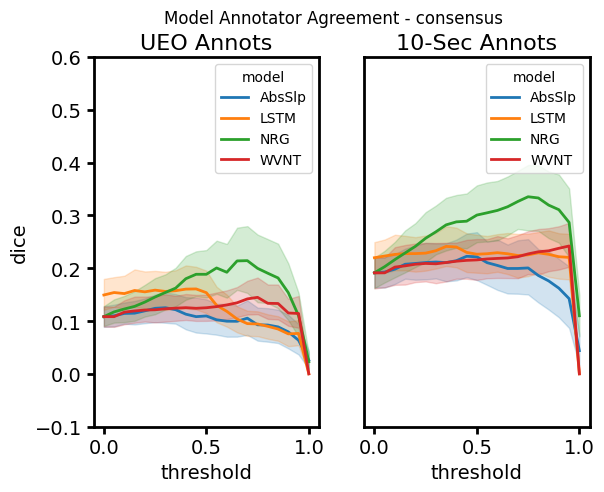

In [20]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
axs[0].set_ylim((-.1,.6))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1])
axs[1].set_ylim((-.1,.6))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')

### Kappa

In [21]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wkappa.pkl"))
mdl_preds = mdl_preds[mdl_preds.stim == 0]
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
# mdl_preds_sorted.head()

In [22]:
melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_kappa',f'sec_chs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
print(np.sort(mdl_preds.columns))
mdl_preds_long.head()

['Patient' 'all_chs' 'approximate_onset' 'iEEG_ID' 'model' 'sec_any'
 'sec_chs_loose' 'sec_chs_loose_any_kappa' 'sec_chs_loose_bool'
 'sec_chs_loose_consensus_kappa' 'sec_chs_strict'
 'sec_chs_strict_any_kappa' 'sec_chs_strict_bool'
 'sec_chs_strict_consensus_kappa' 'sec_consensus' 'stim' 'threshold'
 'to_annotate' 'ueo_any' 'ueo_chs_loose' 'ueo_chs_loose_any_kappa'
 'ueo_chs_loose_bool' 'ueo_chs_loose_consensus_kappa' 'ueo_chs_strict'
 'ueo_chs_strict_any_kappa' 'ueo_chs_strict_bool'
 'ueo_chs_strict_consensus_kappa' 'ueo_consensus' 'ueo_time_consensus']


,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_chs_loose_bool,ueo_chs_loose_consensus_kappa,ueo_chs_loose_any_kappa,sec_chs_strict_bool,sec_chs_strict_any_kappa,sec_chs_loose_bool,sec_chs_loose_consensus_kappa,sec_chs_loose_any_kappa,annot,kappa
0,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, True, True, True, Tru...",0.015914,0.018624,"[True, True, True, True, True, True, True, Tru...",0.067192,"[True, True, True, True, True, True, True, Tru...",0.032431,0.043795,ueo_chs_strict_consensus_kappa,0.024603
1,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, True, True, True, Tru...",0.085851,0.099871,"[True, True, True, True, True, True, True, Tru...",0.250078,"[True, True, True, True, True, True, True, Tru...",0.120995,0.160856,ueo_chs_strict_consensus_kappa,0.127331
2,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, True, True, True, Tru...",0.015914,0.018624,"[True, True, True, True, True, True, True, Tru...",0.067192,"[True, True, True, True, True, True, True, Tru...",0.032431,0.043795,ueo_chs_strict_consensus_kappa,0.024603
3,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, True, True, True, Tru...",0.015914,0.018624,"[True, True, True, True, True, True, True, Tru...",0.067192,"[True, True, True, True, True, True, True, Tru...",0.032431,0.043795,ueo_chs_strict_consensus_kappa,0.024603
4,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, True, True, True, Tru...",0.016696,0.019538,"[True, True, True, True, True, True, True, Tru...",0.068503,"[True, True, True, True, True, True, True, Tru...",0.032431,0.043795,ueo_chs_strict_consensus_kappa,0.026602


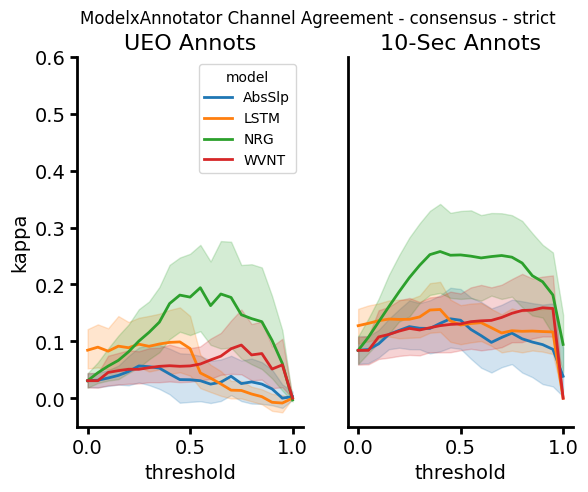

In [23]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
axs[0].set_ylim((-.05,.6))
axs[0].set_title('UEO Annots')
sns.despine(ax=axs[0])
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1],legend=False)
axs[1].set_ylim((-.05,.6))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
sns.despine(ax=axs[1])
fig.suptitle(f'ModelxAnnotator Channel Agreement - {anntype} - {mdl_anntype}')
fig.savefig(ospj(figpath,f'ueo_ch_agreement_{anntype}-{mdl_anntype}.pdf'),transparent=True)

ValueError: Axes(0.125,0.11;0.775x0.77) has no legend attached.

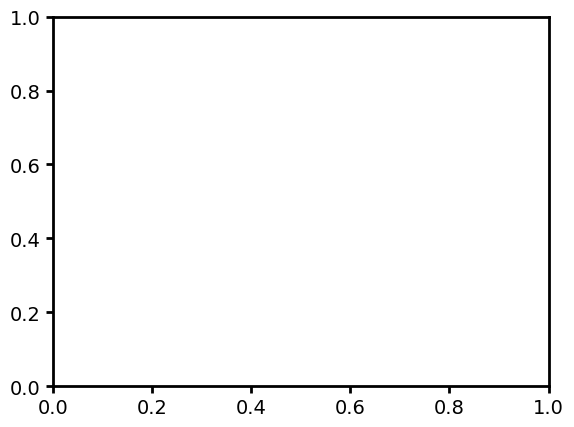

In [36]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'NRG')],x='threshold',y='kappa',hue='Patient',errorbar=None,)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Getting optimal threshold

In [25]:
mask = mdl_preds_sorted.model == 'NRG'
ueo_df = mdl_preds_sorted[mask].groupby('threshold')[f'ueo_chs_{mdl_anntype}_{anntype}_kappa'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')[f'sec_chs_{mdl_anntype}_{anntype}_kappa'].mean()

In [26]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])

0.55
0.4


## Region Agreement Optimization

### Kappa

In [27]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_regions_wkappa.pkl"))
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [28]:
mdl_preds_sorted[[col for col in mdl_preds_sorted.columns if 'kappa' in col]].fillna(0,inplace=True)
melt_cols = [f'ueo_rs_{mdl_anntype}_{anntype}_kappa',f'sec_rs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_consensus_rs,sec_any_rs,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,ueo_rs_loose_any_kappa,sec_rs_strict_any_kappa,sec_rs_loose_consensus_kappa,sec_rs_loose_any_kappa,annot,kappa
0,CHOP005,CHOP005,AbsSlp,1.0,68881.53,68881.53,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.007220,0.003466,0.00722,0.031891,0.011299,0.031891,ueo_rs_strict_consensus_kappa,0.003466
1,CHOP005,CHOP005,LSTM,1.0,68881.53,68881.53,0.00,"[LK02, LK04, LK06, LK07, LK08, LK09, LK10, LK1...","[LA01, LA02, LA03, LA04, LA05, LB02, LB03, LB0...","[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.023437,0.003466,0.00722,0.065421,0.011299,0.031891,ueo_rs_strict_consensus_kappa,0.011299
2,CHOP005,CHOP005,NRG,1.0,68881.53,68881.53,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.007220,0.003466,0.00722,0.031891,0.011299,0.031891,ueo_rs_strict_consensus_kappa,0.003466
3,CHOP005,CHOP005,WVNT,1.0,68881.53,68881.53,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.007220,0.003466,0.00722,0.031891,0.011299,0.031891,ueo_rs_strict_consensus_kappa,0.003466
4,CHOP005,CHOP005,AbsSlp,1.0,68881.53,68881.53,0.05,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.007220,0.003466,0.00722,0.031891,0.011299,0.031891,ueo_rs_strict_consensus_kappa,0.003466


In [29]:
mdl_preds_sorted.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'ueo_rs_strict',
       'ueo_rs_loose', 'sec_rs_strict', 'sec_rs_loose', 'all_rs',
       'ueo_consensus_rs', 'ueo_any_rs', 'sec_consensus_rs', 'sec_any_rs',
       'ueo_rs_strict_consensus_kappa', 'ueo_rs_strict_any_kappa',
       'ueo_rs_loose_consensus_kappa', 'ueo_rs_loose_any_kappa',
       'sec_rs_strict_consensus_kappa', 'sec_rs_strict_any_kappa',
       'sec_rs_loose_consensus_kappa', 'sec_rs_loose_any_kappa'],
      dtype='object')

Text(0.5, 0.98, 'ModelxAnnotator Region Agreement - consensus - strict')

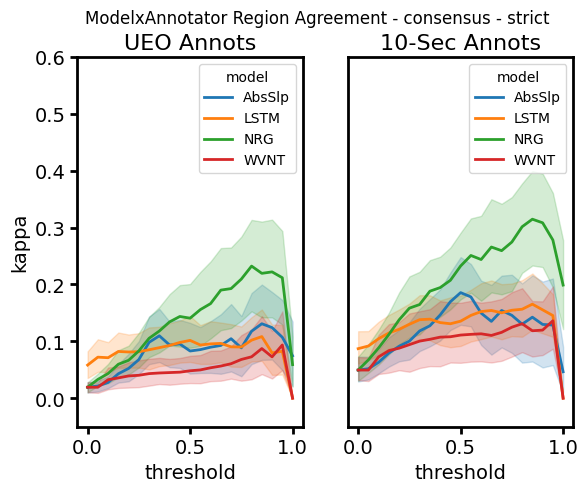

In [30]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
axs[0].set_ylim((-.05,.6))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_rs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1])
axs[1].set_ylim((-.05,.6))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'ModelxAnnotator Region Agreement - {anntype} - {mdl_anntype}')

In [31]:
mdl_preds_long[mdl_preds_long.annot == f'sec_rs_{mdl_anntype}_{anntype}_kappa']

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_consensus_rs,sec_any_rs,ueo_rs_strict_any_kappa,ueo_rs_loose_consensus_kappa,ueo_rs_loose_any_kappa,sec_rs_strict_any_kappa,sec_rs_loose_consensus_kappa,sec_rs_loose_any_kappa,annot,kappa
5376,CHOP005,CHOP005,AbsSlp,1.0,68881.5300,68881.5300,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.007220,0.003466,0.007220,0.031891,0.011299,0.031891,sec_rs_strict_consensus_kappa,0.011299
5377,CHOP005,CHOP005,LSTM,1.0,68881.5300,68881.5300,0.00,"[LK02, LK04, LK06, LK07, LK08, LK09, LK10, LK1...","[LA01, LA02, LA03, LA04, LA05, LB02, LB03, LB0...","[LK02, LK04, LK05, LK06, LK07, LK08, LK09, LK1...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.023437,0.003466,0.007220,0.065421,0.011299,0.031891,sec_rs_strict_consensus_kappa,0.023437
5378,CHOP005,CHOP005,NRG,1.0,68881.5300,68881.5300,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.007220,0.003466,0.007220,0.031891,0.011299,0.031891,sec_rs_strict_consensus_kappa,0.011299
5379,CHOP005,CHOP005,WVNT,1.0,68881.5300,68881.5300,0.00,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.007220,0.003466,0.007220,0.031891,0.011299,0.031891,sec_rs_strict_consensus_kappa,0.011299
5380,CHOP005,CHOP005,AbsSlp,1.0,68881.5300,68881.5300,0.05,"[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LB0...","[LK02, LK03, LK04, LK05, LK06, LK07, LK08, LK0...",...,"[Left-Amygdala, Left-Hippocampus, ctx-lh-later...","[Left-Amygdala, Left-Hippocampus, ctx-lh-prece...",0.007220,0.003466,0.007220,0.031891,0.011299,0.031891,sec_rs_strict_consensus_kappa,0.011299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,HUP266,HUP266_phaseII,WVNT,0.0,418859.4191,418859.4191,0.95,"[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, R1PO0...","[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, R1PO0...","[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, R1PO0...",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",-0.041667,-0.127168,-0.092715,-0.041667,-0.092715,-0.092715,sec_rs_strict_consensus_kappa,-0.041667
10748,HUP266,HUP266_phaseII,AbsSlp,0.0,418859.4191,418859.4191,1.00,[],[],"[RA05, RF02]",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sec_rs_strict_consensus_kappa,0.000000
10749,HUP266,HUP266_phaseII,LSTM,0.0,418859.4191,418859.4191,1.00,[],[],[],...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sec_rs_strict_consensus_kappa,0.000000
10750,HUP266,HUP266_phaseII,NRG,0.0,418859.4191,418859.4191,1.00,[],[],"[RA05, RF02, RF06, RPC06, RPC08, RT01, RU01]",...,"[ right posterior cingulate , right entorhina...","[ right posterior cingulate , right entorhina...",0.000000,0.000000,0.000000,-0.363636,-0.363636,-0.363636,sec_rs_strict_consensus_kappa,-0.363636


### Getting optimal threshold

In [32]:
mask = mdl_preds_sorted.model == 'AbsSlp'
ueo_df = mdl_preds_sorted[mask].groupby('threshold')['ueo_rs_strict_consensus_kappa'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')['sec_rs_strict_consensus_kappa'].mean()

In [33]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])
print(np.mean((ueo_df.index[ueo_df.iloc[:].argmax()],sec_df.index[sec_df.iloc[:].argmax()])))

0.8500000000000001
0.5
0.675


In [34]:
sum((mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'LSTM'))

1344

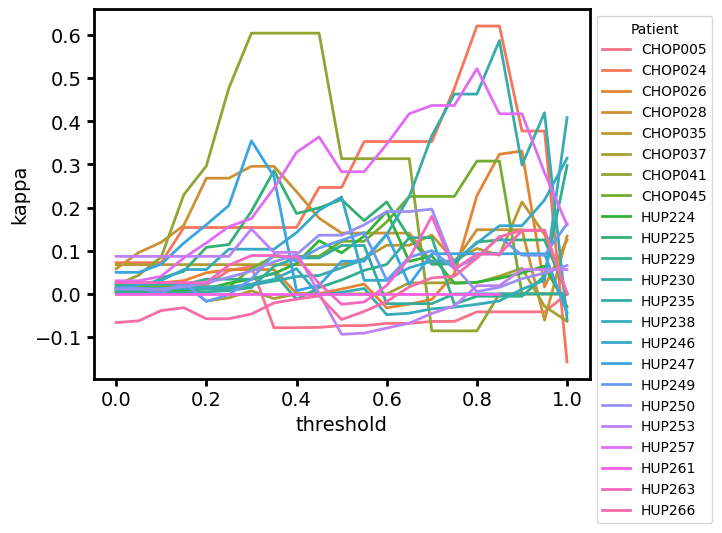

In [35]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_rs_{mdl_anntype}_{anntype}_kappa') & (mdl_preds_long.model == 'AbsSlp')],x='threshold',y='kappa',hue='Patient',errorbar=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))